In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as img


import torch
import torchvision

from pathlib import Path
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from PIL import Image
from typing import List
import torchvision.transforms.functional as TF

/home/akaur101/.conda/envs/akaur_pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/akaur101/.conda/envs/akaur_pytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


In [2]:
train_image_path = "/home/akaur101/data/t006.tif"
train_mask_path  = "/home/akaur101/data/man_seg006.tif"

test_image_path = "/home/akaur101/data/t007.tif"
test_mask_path  = "/home/akaur101/data/man_seg007.tif"

In [3]:
train_image = plt.imread(train_image_path)
train_mask  = plt.imread(test_mask_path)

test_image  = plt.imread(test_image_path)
test_mask   = plt.imread(test_mask_path)

In [5]:
train_mask[train_mask < 0.5] = 0
train_mask[train_mask >= 0.5] = 1

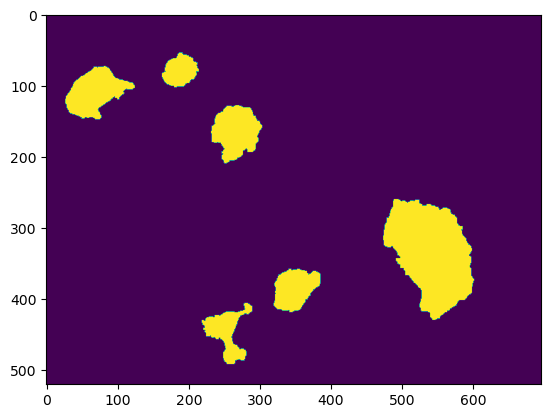

In [6]:
plt.imshow(train_mask)
plt.savefig("train_image")

In [4]:
train_im_nor = train_image/np.max(train_image)
train_mas_nor = train_mask/np.max(train_mask)

test_im_nor = train_image/np.max(test_image)
test_mas_nor = train_mask/np.max(test_mask)

In [8]:
test = np.pad(test_image, ((1,1), (1,2)), mode = 'constant')
test.shape

(522, 699)

In [5]:
image_padded = np.pad(train_im_nor, 40, mode = 'constant')
mask_padded  = np.pad(train_mas_nor,  40, mode = 'constant')

test_image_padded = np.pad(test_im_nor, 40, mode = 'constant')
test_mask_padded  = np.pad(test_mas_nor,  40, mode = 'constant')

In [10]:
image_padded.shape

(600, 776)

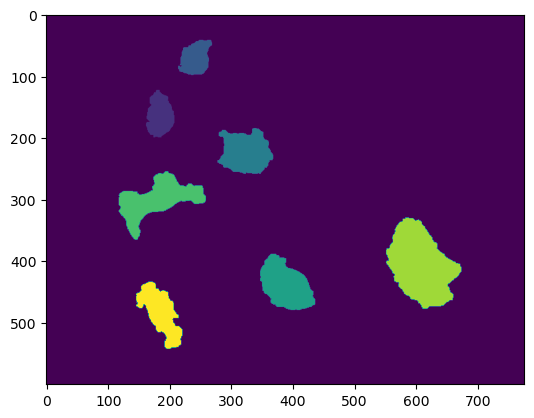

In [11]:
plt.imshow(mask_padded)
plt.savefig("padded mask")

In [6]:
train_image_list = []
train_mask_list  = []

snap_image = np.empty([80, 80])
snap_mask  = np.empty([3, 3])

x =  np.shape(image_padded)[0]
y =  np.shape(image_padded)[1]

for i in range(40,x-40):
    for j in range(40,y-40):
        current    = image_padded[i][j]
        snap_image = image_padded[i-40:i+40, j-40:j+40]
        snap_mask  = mask_padded[i-1:i+2, j-1:j+2]
        train_image_list.append(snap_image)
        train_mask_list.append(snap_mask)

In [7]:
test_image_list = []
test_mask_list  = []

snap_image = np.empty([80, 80])
snap_mask  = np.empty([3, 3])

x =  np.shape(test_image_padded)[0]
y =  np.shape(test_image_padded)[1]

for i in range(40,x-40, 3):
    for j in range(40,y-40, 3):
        current    = test_image_padded[i][j]
        snap_image = test_image_padded[i-40:i+40, j-40:j+40]
        snap_mask  = test_mask_padded[i-1:i+2, j-1:j+2]
        test_image_list.append(snap_image)
        test_mask_list.append(snap_mask)
        

#train_tensor = torch.Tensor(train_list)

In [8]:
len(train_image_list)

361920

In [9]:
len(test_image_list)

40368

In [10]:
class celldata(Dataset):
    def __init__(self, image_list, mask_list, transforms):
        self.image_list = image_list
        self.mask_list  = mask_list
        self.transforms = transforms
        
    def __len__(self):
        
        return len((self.image_list))
    
    def __getitem__(self, index):
        image = self.image_list[index].astype(float)
        mask  = self.mask_list[index].astype(float)
        
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        
#         image = image[None, :]
#         mask  = mask[None, :]
        
        return (image, mask)

In [11]:
transforms = transforms.ToTensor()

In [12]:
train_dataset = celldata(image_list = train_image_list, 
                         mask_list  = train_mask_list,
                         transforms = transforms)
train_loader  = DataLoader(train_dataset, shuffle = True, batch_size = 50)

In [13]:
test_dataset = celldata(image_list = test_image_list, 
                         mask_list  = test_mask_list,
                         transforms = transforms)
test_loader  = DataLoader(test_dataset, batch_size = 233)

In [14]:
#creating a model
    
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_conv, self).__init__()

        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
                    nn.BatchNorm2d(num_features = out_channels),
                    nn.ReLU(inplace = True),
                    nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
                    nn.BatchNorm2d(num_features = out_channels),
                    nn.ReLU(inplace = True))
        
    def forward(self, x):
        return self.conv(x)
    

class net(nn.Module):
    
    def __init__(self):
        super(net, self).__init__()
        
        
        self.maxpool  = nn.MaxPool2d(kernel_size=2, stride= 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride= 3)
        self.conv1    = double_conv(1, 64)
        self.conv2    = double_conv(64,128)
        self.conv3    = double_conv(128,256)
        self.conv4    = double_conv(256, 512)
        self.conv5    = double_conv(512,1024)
        self.conv6    = nn.Conv2d(1024, 1, kernel_size = 3, stride = 1, padding = 1)
        
    def forward(self, image):
        
        x1  = self.conv1(image)
        x2  = self.maxpool(x1)
        x3  = self.conv2(x2)
        x4  = self.maxpool(x3)
        x5  = self.conv3(x4)
        x6  = self.maxpool(x5)
        x7  = self.conv4(x6)
        x8  = self.maxpool2(x7)
        x9  = self.conv5(x8)
        x10 = self.conv6(x9)
        return(x10)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model  = net()
model  = model.float()
model  = model.to(device=device)

In [16]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
running_loss_list = []
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        images, masks = data
        images = images.to(device=device)
        masks = masks.to(device=device)
        optimizer.zero_grad()    #empty the gradients
        
        outputs = model(images.float())
        #print(outputs)
        loss = criterion(outputs, masks.float())
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(
                 (epoch + 1, i + 1, running_loss / 100)
                 )
            running_loss_list.append(running_loss)
            running_loss = 0.0
print('Finished Training')

(1, 100, 0.08490536139346659)
(1, 200, 0.05049657234922052)
(1, 300, 0.0530049477214925)
(1, 400, 0.04531447156798094)
(1, 500, 0.04520052448380738)
(1, 600, 0.04304564036196098)
(1, 700, 0.043696477008634244)
(1, 800, 0.04189719654503279)
(1, 900, 0.037406774025876076)
(1, 1000, 0.040065312511869705)
(1, 1100, 0.030921336996252647)
(1, 1200, 0.03666101894690655)
(1, 1300, 0.03948095079511404)
(1, 1400, 0.04496150785358623)
(1, 1500, 0.0375078006205149)
(1, 1600, 0.0343467548431363)
(1, 1700, 0.03509797769074794)
(1, 1800, 0.03312510458315956)
(1, 1900, 0.031201042627362768)
(1, 2000, 0.03171596735628555)
(1, 2100, 0.031683775648125447)
(1, 2200, 0.032916028504259884)
(1, 2300, 0.034756380620237906)
(1, 2400, 0.03277154046547366)
(1, 2500, 0.03316028443106916)
(1, 2600, 0.03162977055930241)
(1, 2700, 0.03476740116602741)
(1, 2800, 0.03347625888563925)
(1, 2900, 0.03290442393510602)
(1, 3000, 0.033783110933454735)
(1, 3100, 0.036040695217816394)
(1, 3200, 0.03405466804921162)
(1, 3300, 

(4, 4700, 0.027806558480215245)
(4, 4800, 0.027017641550687584)
(4, 4900, 0.027421336612738455)
(4, 5000, 0.024958913545635363)
(4, 5100, 0.028345136176294545)
(4, 5200, 0.0261161971182878)
(4, 5300, 0.02686031667067425)
(4, 5400, 0.024696724949722013)
(4, 5500, 0.025729872851487697)
(4, 5600, 0.028355504748541305)
(4, 5700, 0.0275132146841554)
(4, 5800, 0.027002999592249548)
(4, 5900, 0.027192544596679226)
(4, 6000, 0.02679595792302905)
(4, 6100, 0.028328969913268123)
(4, 6200, 0.024696577409283122)
(4, 6300, 0.027296348404170202)
(4, 6400, 0.027962580986213653)
(4, 6500, 0.03139149941798678)
(4, 6600, 0.028167310377751564)
(4, 6700, 0.027403461695233774)
(4, 6800, 0.026961034695597165)
(4, 6900, 0.028179677747721142)
(4, 7000, 0.024342343912106018)
(4, 7100, 0.028010672342333863)
(4, 7200, 0.027640411926108756)
(5, 100, 0.025837053683608814)
(5, 200, 0.024690214087073628)
(5, 300, 0.02500573767434673)
(5, 400, 0.028541768087266065)
(5, 500, 0.02716634860870613)
(5, 600, 0.02558026841

(8, 2000, 0.026720761569233673)
(8, 2100, 0.026034433714109895)
(8, 2200, 0.026616970592141628)
(8, 2300, 0.029656754937697337)
(8, 2400, 0.024340213809716432)
(8, 2500, 0.024899923881030687)
(8, 2600, 0.02878967371917256)
(8, 2700, 0.026378259642853338)
(8, 2800, 0.025751242985293552)
(8, 2900, 0.022987908196596435)
(8, 3000, 0.024081421608351795)
(8, 3100, 0.023901669698452678)
(8, 3200, 0.024164785437733344)
(8, 3300, 0.026187994710801413)
(8, 3400, 0.025262803346481524)
(8, 3500, 0.024705583208784673)
(8, 3600, 0.022143052224617037)
(8, 3700, 0.02319010131308966)
(8, 3800, 0.025530589675045227)
(8, 3900, 0.02698427199562314)
(8, 4000, 0.023322310725800436)
(8, 4100, 0.024523063118600846)
(8, 4200, 0.02586884566652706)
(8, 4300, 0.0271090764634301)
(8, 4400, 0.030263845504227813)
(8, 4500, 0.028894073214067978)
(8, 4600, 0.02720484255406678)
(8, 4700, 0.023655200736478435)
(8, 4800, 0.028348531049646936)
(8, 4900, 0.027599879077656625)
(8, 5000, 0.02489093371138429)
(8, 5100, 0.0247

In [20]:
torch.save(model.state_dict(), "/home/akaur101/data/rgcnet_dict")

In [21]:
torch.save(model, "/home/akaur101/data/rgcnet")

In [ ]:
# mod = net()
# mod.load_state_dict(torch.load("/home/akaur101/data/rgcnet_dict"))

In [22]:
mod = torch.load("/home/akaur101/data/rgcnet")
mod.eval()

net(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): double_conv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [24]:

output_list = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, masks = data
        images = images.to(device=device)
        masks = masks.to(device=device)
        pred = mod(images.float())
        #print(torch.unique(pred))
        pred_np = torch.Tensor.cpu(pred).numpy()
        output_list.append(pred_np)
print('Finished Testing')

Finished Testing


In [25]:
pred

tensor([[[[-24.6947, -27.7478, -24.0356],
          [-26.4543, -28.4282, -26.2025],
          [-21.9400, -23.9015, -22.4893]]],


        [[[-23.6251, -26.5208, -22.9374],
          [-24.9712, -26.8362, -24.8093],
          [-21.0071, -22.9760, -21.7724]]],


        [[[-22.8116, -25.7626, -22.7645],
          [-24.0507, -25.9521, -24.6112],
          [-21.1692, -23.1427, -22.2943]]],


        [[[-22.2557, -25.5784, -23.1477],
          [-23.2765, -25.5171, -24.8415],
          [-20.7827, -22.9294, -22.4729]]],


        [[[-23.1421, -26.2673, -23.6633],
          [-24.0790, -26.0149, -25.2945],
          [-21.5659, -23.5317, -22.8782]]],


        [[[-21.8975, -24.4260, -21.7781],
          [-23.0074, -24.3620, -23.6015],
          [-20.4782, -22.1013, -21.4764]]],


        [[[-20.9174, -23.1407, -20.3873],
          [-21.9144, -23.0408, -22.1235],
          [-19.8434, -21.3486, -20.6017]]],


        [[[-18.1995, -20.0527, -17.9170],
          [-19.1307, -19.9320, -19.6244],
      

In [26]:
finale = []
for i in range(len(output_list)):
    if i < 173:
        temp = np.concatenate(np.squeeze(output_list[i]), axis = 1)
        finale.append(temp)
#finale.append(last_arr)

In [27]:
final_image = np.array(finale).reshape((173*3,699))

In [28]:
final_image.shape

(519, 699)

In [29]:
np.unique(final_image)

array([-57.52362 , -57.023464, -55.869846, ...,   9.662502,   9.792666,
         9.905279], dtype=float32)

In [31]:
final_image[final_image < 0.5] = 0
final_image[final_image >= 0.5] = 1

np.unique(final_image)

array([0., 1.], dtype=float32)

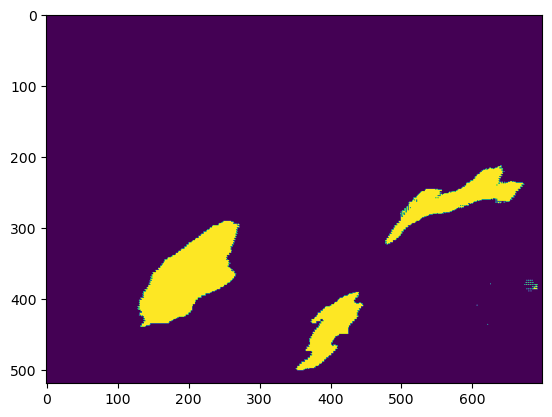

In [32]:
plt.imshow(final_image)
plt.savefig("final_output_im_thresh")

In [57]:
test_mask[test_mask < 0.5] = 0
test_mask[test_mask >= 0.5] = 1

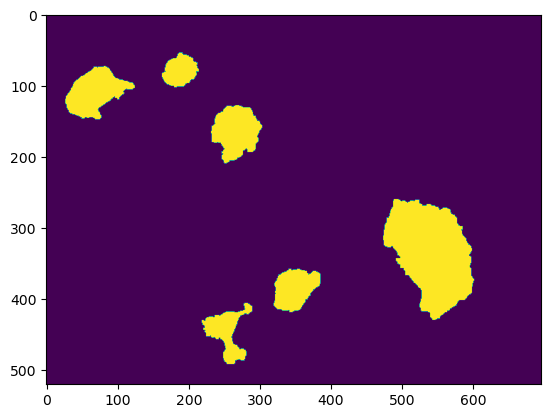

In [58]:
plt.imshow(test_mask)
plt.savefig("testmask")

In [140]:
import sklearn

In [141]:
from sklearn.metrics import jaccard_score

In [144]:
#jaccard_score(final_image[0], test_mask[0])